<a href="https://colab.research.google.com/github/jm5159/E4511-2021-Mao/blob/master/modeling_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install AMPL packages

In [2]:
%tensorflow_version 1.x

In [3]:

! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

# ! wget -c https://repo.anaconda.com/miniconda/Miniconda3-py37_4.9.2-Linux-x86_64.sh 
# ! chmod +x Miniconda3-py37_4.9.2-Linux-x86_64.sh
# ! time bash Miniconda3-py37_4.9.2-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

!pip install mordred
!pip install --upgrade bravado
!pip install molvs

!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

--2021-04-02 02:31:33--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   243MB/s    in 2.1s    

2021-04-02 02:31:35 (243 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-navigator==1.9.7=py37_0
    - anacond

In [4]:
!wget https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/CYP3A4_cur_delaney.csv

--2021-04-02 02:37:54--  https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/CYP3A4_cur_delaney.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3924905 (3.7M) [text/plain]
Saving to: ‘CYP3A4_cur_delaney.csv’

CYP3A4_cur_delaney. 100%[===================>]   3.74M  21.5MB/s    in 0.2s    

2021-04-02 02:37:55 (21.5 MB/s) - ‘CYP3A4_cur_delaney.csv’ saved [3924905/3924905]



In [5]:
!pip install hyperopt

     |████████████████████████████████| 972kB 4.6MB/s 


### Load packages and dataset

In [6]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")

import pandas as pd
import os, json, sys, glob, pickle

from atomsci.ddm.pipeline import parameter_parser as parse
import atomsci.ddm.pipeline.model_pipeline as mp
from atomsci.ddm.pipeline import perf_data

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [7]:
h1 = pd.read_csv("CYP3A4_cur_delaney.csv")

In [9]:
h1=h1.iloc[:,1:]

In [13]:
h1

,compound_id,base_rdkit_smiles,relation,pXC50,active,rdkit_smiles,inchi_key,Compound_ID,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,CHEMBL1537880,Cc1ccc(-c2nnc(C)c(N3CC(C)OC(C)C3)n2)cc1,NaN,5.300000,0,Cc1ccc(-c2nnc(C)c(N3CC(C)OC(C)C3)n2)cc1,WNUWUYIZADTROQ-UHFFFAOYSA-N,WNUWUYIZADTROQ-UHFFFAOYSA-N,5.300000,NaN,0.0,0
1,CHEMBL1515033,CS(=O)(=O)N1CCC[C@@]2(CCN(c3ccncc3)C2)C1,NaN,5.100000,0,CS(=O)(=O)N1CCC[C@@]2(CCN(c3ccncc3)C2)C1,LFQJIVPPRFXMAC-AWEZNQCLSA-N,LFQJIVPPRFXMAC-AWEZNQCLSA-N,5.100000,NaN,0.0,0
2,CHEMBL3422242,Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...,<,4.522879,0,Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...,HVEVDFRWOQHAPJ-CKMNQQOVSA-N,HVEVDFRWOQHAPJ-CKMNQQOVSA-N,4.522879,NaN,0.0,0
3,CHEMBL1526043,N#Cc1cccc(-c2nc3cnc(N4CCOCC4)nc3n(C3CC3)c2=O)c1,NaN,4.400000,0,N#Cc1cccc(-c2nc3cnc(N4CCOCC4)nc3n(C3CC3)c2=O)c1,QIZLBSOCEJVBTG-UHFFFAOYSA-N,QIZLBSOCEJVBTG-UHFFFAOYSA-N,4.400000,NaN,0.0,0
4,CHEMBL3145019,Cc1nn(C(C)(C)C)c(O)c1Sc1ccc(Cl)cc1,NaN,4.800000,0,Cc1nn(C(C)(C)C)c(O)c1Sc1ccc(Cl)cc1,IYIGLQSFYOLXCS-UHFFFAOYSA-N,IYIGLQSFYOLXCS-UHFFFAOYSA-N,4.800000,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18637,CHEMBL3932169,CC(C)[C@@H]1c2nn(-c3cccc(S(C)(=O)=O)c3)cc2CN1c...,NaN,5.515700,0,CC(C)[C@@H]1c2nn(-c3cccc(S(C)(=O)=O)c3)cc2CN1c...,NCZXBZJVJRJUSC-GOSISDBHSA-N,NCZXBZJVJRJUSC-GOSISDBHSA-N,5.515700,NaN,0.0,0
18638,CHEMBL4210866,N[C@@H]1CCC=C(c2ccc(F)cc2)[C@H]1CNc1cc(F)c(S(=...,NaN,4.481486,0,N[C@@H]1CCC=C(c2ccc(F)cc2)[C@H]1CNc1cc(F)c(S(=...,BSNVRJYSKXDALK-VQIMIIECSA-N,BSNVRJYSKXDALK-VQIMIIECSA-N,4.481486,NaN,0.0,0
18639,CHEMBL1465534,O=[N+]([O-])c1cccc(-c2nnn(C34CC5CC(CC(C5)C3)C4...,NaN,5.050000,0,O=[N+]([O-])c1cccc(-c2nnn(C34CC5CC(CC(C5)C3)C4...,ILMKPNZNEYHDGO-UHFFFAOYSA-N,ILMKPNZNEYHDGO-UHFFFAOYSA-N,5.050000,NaN,0.0,0
18640,CHEMBL3237445,Cc1nccc2c3cnc(Nc4ccc(N5CCNCC5)cn4)nc3n(C3CCCC3...,<,5.000000,0,Cc1nccc2c3cnc(Nc4ccc(N5CCNCC5)cn4)nc3n(C3CCCC3...,FLNHSHVOGZEONH-UHFFFAOYSA-N,FLNHSHVOGZEONH-UHFFFAOYSA-N,5.000000,NaN,0.0,0


In [10]:
h1.shape

(18642, 12)

### Split the dataset

In [14]:
train_file = "CYP3A4_cur_delaney.csv"
response_col = "active"
compound_id = "compound_id"
smiles_col = "rdkit_smiles"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "classification",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "False",
        "split_only": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "split"
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-04-02 02:46:13,748 Splitting data by scaffold
2021-04-02 02:46:26,679 Dataset split table saved to /CYP3A4_cur_delaney_train_valid_test_scaffold_45f11ee4-f43a-4b81-891b-1883564bfa87.csv


### Train an initial model

In [24]:
listing = glob.glob(os.path.join("/", "CYP3A4_cur_delaney_train_valid_test_scaffold_*"))
name = listing[0]
split_uuid = name.split("_")[-1].split(".")[0]
response_col = "active"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "classification",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "ampl_output"
    }

In [25]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-04-02 02:56:40,342 Previous dataset split restored
2021-04-02 02:56:59,873 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/f938a010-00c0-4186-b81b-95050aa81af2/model_metadata.json
2021-04-02 02:57:00,128 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/f938a010-00c0-4186-b81b-95050aa81af2/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_f938a010-00c0-4186-b81b-95050aa81af2.tar.gz


In [26]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['roc_auc_score']:.3f}")


R2 score of validation set: 0.813


### Train an model with uncertainty prediction

In [20]:
listing = glob.glob(os.path.join("/", "CYP3A4_cur_delaney_train_valid_test_scaffold_*"))
name = listing[0]
split_uuid = name.split("_")[-1].split(".")[0]
response_col = "active"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "classification",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "ampl_output",
        "uncertainty": "True"
    }

In [21]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-04-02 02:53:06,439 Previous dataset split restored
2021-04-02 02:53:27,029 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/dd3ccbf0-362f-4cdf-992b-1d68674fbfec/model_metadata.json
2021-04-02 02:53:27,283 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/dd3ccbf0-362f-4cdf-992b-1d68674fbfec/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_dd3ccbf0-362f-4cdf-992b-1d68674fbfec.tar.gz


In [22]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['roc_auc_score']:.3f}")

R2 score of validation set: 0.816


In [23]:
pred_df = pl.predict_on_dataframe(h1)
pred_df = pred_df.merge(h1[["rdkit_smiles", "active"]], on="rdkit_smiles")
pred_df = pred_df.assign(pred_error=pred_df.active-pred_df.pred)

2021-04-02 02:55:00,864 Featurizing data...


KeyboardInterrupt: ignored

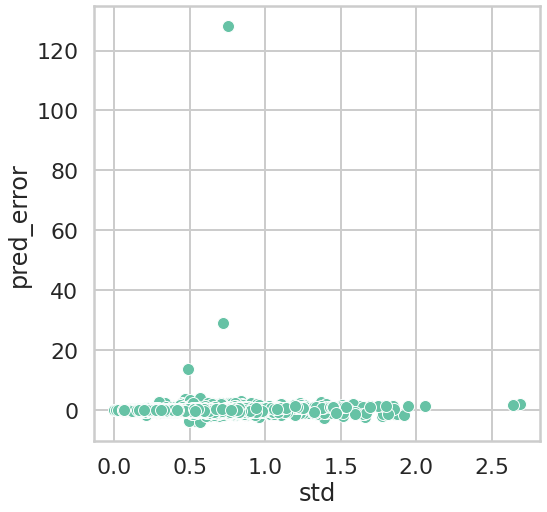

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sns.scatterplot(data=pred_df, x="std", y="pred_error", ax=ax)

### Grid search
#### Tunable parameters for Random Forest models
- rf_estimators: number of estimators to use in random forest models
- rf_max_depth: the maximum depth of a decision tree in the random forest
- rf_max_features: max number of features to split random forest nodes

In [ ]:
estimators = [16,32,64,128]
depth=[16,32,64,128]
features=[16,32,64,128]

rfe_list = []
rfd_list = []
rff_list = []
valid_auc_list = []
for rf_estimator in estimators:
    for rf_depth in depth:
        for rf_feature in features:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_auc = pred_results['roc_auc_score']
            valid_auc_list.append(valid_auc)
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_auc: {valid_auc}")

number of features: 1024


2021-04-02 03:05:21,098 Previous dataset split restored
2021-04-02 03:05:26,737 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/55dee9d4-708c-4d77-824a-424b97bf1dd7/model_metadata.json
2021-04-02 03:05:26,748 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/55dee9d4-708c-4d77-824a-424b97bf1dd7/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_55dee9d4-708c-4d77-824a-424b97bf1dd7.tar.gz
rf_estimators: 16, rf_max_depth: 16, rf_max_features: 16, valid_auc: 0.8230336762804294
number of features: 1024


2021-04-02 03:06:41,279 Previous dataset split restored
2021-04-02 03:06:47,079 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/84c61750-a585-4779-99fa-ac8819438b4d/model_metadata.json
2021-04-02 03:06:47,091 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/84c61750-a585-4779-99fa-ac8819438b4d/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_84c61750-a585-4779-99fa-ac8819438b4d.tar.gz
rf_estimators: 16, rf_max_depth: 16, rf_max_features: 32, valid_auc: 0.7802271321751841
number of features: 1024


2021-04-02 03:08:01,608 Previous dataset split restored
2021-04-02 03:08:07,669 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/5c22d317-bc56-48ae-b672-3f63b3773a16/model_metadata.json
2021-04-02 03:08:07,678 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/5c22d317-bc56-48ae-b672-3f63b3773a16/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_5c22d317-bc56-48ae-b672-3f63b3773a16.tar.gz
rf_estimators: 16, rf_max_depth: 16, rf_max_features: 64, valid_auc: 0.7447124304267162
number of features: 1024


2021-04-02 03:09:22,389 Previous dataset split restored
2021-04-02 03:09:28,865 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/c6ec13a7-455a-4c0f-82a1-775efa9f5b3f/model_metadata.json
2021-04-02 03:09:28,874 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/c6ec13a7-455a-4c0f-82a1-775efa9f5b3f/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_c6ec13a7-455a-4c0f-82a1-775efa9f5b3f.tar.gz
rf_estimators: 16, rf_max_depth: 16, rf_max_features: 128, valid_auc: 0.7731714173272615
number of features: 1024


2021-04-02 03:10:43,430 Previous dataset split restored
2021-04-02 03:10:49,223 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/95c3d6ce-22bf-41a7-9210-170ce6e14db7/model_metadata.json
2021-04-02 03:10:49,238 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/95c3d6ce-22bf-41a7-9210-170ce6e14db7/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_95c3d6ce-22bf-41a7-9210-170ce6e14db7.tar.gz
rf_estimators: 16, rf_max_depth: 32, rf_max_features: 16, valid_auc: 0.772738516894361
number of features: 1024


2021-04-02 03:12:03,686 Previous dataset split restored
2021-04-02 03:12:09,554 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/8116dfe6-5673-40d7-b599-313ac441d4e9/model_metadata.json
2021-04-02 03:12:09,566 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/8116dfe6-5673-40d7-b599-313ac441d4e9/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_8116dfe6-5673-40d7-b599-313ac441d4e9.tar.gz
rf_estimators: 16, rf_max_depth: 32, rf_max_features: 32, valid_auc: 0.7350368246472142
number of features: 1024


2021-04-02 03:13:24,394 Previous dataset split restored
2021-04-02 03:13:30,673 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/8d101745-7319-41ed-910d-cd069d19eda5/model_metadata.json
2021-04-02 03:13:30,683 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/8d101745-7319-41ed-910d-cd069d19eda5/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_8d101745-7319-41ed-910d-cd069d19eda5.tar.gz
rf_estimators: 16, rf_max_depth: 32, rf_max_features: 64, valid_auc: 0.7457300275482094
number of features: 1024


2021-04-02 03:14:45,508 Previous dataset split restored
2021-04-02 03:14:52,619 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/0eb50e20-7023-423f-8efc-62c285018c4e/model_metadata.json
2021-04-02 03:14:52,629 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/0eb50e20-7023-423f-8efc-62c285018c4e/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_0eb50e20-7023-423f-8efc-62c285018c4e.tar.gz
rf_estimators: 16, rf_max_depth: 32, rf_max_features: 128, valid_auc: 0.7978298757519537
number of features: 1024


2021-04-02 03:16:07,429 Previous dataset split restored
2021-04-02 03:16:13,209 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/44fe776c-ce7f-47da-be0d-e8d6ee5fccc9/model_metadata.json
2021-04-02 03:16:13,225 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/44fe776c-ce7f-47da-be0d-e8d6ee5fccc9/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_44fe776c-ce7f-47da-be0d-e8d6ee5fccc9.tar.gz
rf_estimators: 16, rf_max_depth: 64, rf_max_features: 16, valid_auc: 0.8130095013211897
number of features: 1024


2021-04-02 03:17:27,573 Previous dataset split restored
2021-04-02 03:17:33,497 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/d36bbfd3-abc4-4c90-88d3-2ab969f8abf7/model_metadata.json
2021-04-02 03:17:33,510 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/d36bbfd3-abc4-4c90-88d3-2ab969f8abf7/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_d36bbfd3-abc4-4c90-88d3-2ab969f8abf7.tar.gz
rf_estimators: 16, rf_max_depth: 64, rf_max_features: 32, valid_auc: 0.7971833361443752
number of features: 1024


2021-04-02 03:18:48,057 Previous dataset split restored
2021-04-02 03:18:54,298 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/d8b24221-be8f-4bb8-a4ae-cca58916d7fa/model_metadata.json
2021-04-02 03:18:54,309 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/d8b24221-be8f-4bb8-a4ae-cca58916d7fa/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_d8b24221-be8f-4bb8-a4ae-cca58916d7fa.tar.gz
rf_estimators: 16, rf_max_depth: 64, rf_max_features: 64, valid_auc: 0.7686568842412999
number of features: 1024


2021-04-02 03:20:08,745 Previous dataset split restored
2021-04-02 03:20:15,772 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/a943dd37-bed0-4259-a9fa-b176cbd67f1c/model_metadata.json
2021-04-02 03:20:15,782 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/a943dd37-bed0-4259-a9fa-b176cbd67f1c/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_a943dd37-bed0-4259-a9fa-b176cbd67f1c.tar.gz
rf_estimators: 16, rf_max_depth: 64, rf_max_features: 128, valid_auc: 0.7688199246640804
number of features: 1024


2021-04-02 03:21:30,423 Previous dataset split restored
2021-04-02 03:21:36,163 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/cbb2ddd0-97f4-4adb-8592-04adb0eb3a61/model_metadata.json
2021-04-02 03:21:36,178 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/cbb2ddd0-97f4-4adb-8592-04adb0eb3a61/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_cbb2ddd0-97f4-4adb-8592-04adb0eb3a61.tar.gz
rf_estimators: 16, rf_max_depth: 128, rf_max_features: 16, valid_auc: 0.7754314949120145
number of features: 1024


2021-04-02 03:22:50,889 Previous dataset split restored
2021-04-02 03:22:56,761 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/521f1fe5-e1a3-4329-9fad-dbc5dd55b96b/model_metadata.json
2021-04-02 03:22:56,774 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/521f1fe5-e1a3-4329-9fad-dbc5dd55b96b/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_521f1fe5-e1a3-4329-9fad-dbc5dd55b96b.tar.gz
rf_estimators: 16, rf_max_depth: 128, rf_max_features: 32, valid_auc: 0.7741946365322988
number of features: 1024


2021-04-02 03:24:11,220 Previous dataset split restored
2021-04-02 03:24:17,418 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/f3a1f2e5-6345-4e2a-8fe3-2d91001eeca5/model_metadata.json
2021-04-02 03:24:17,429 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/f3a1f2e5-6345-4e2a-8fe3-2d91001eeca5/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_f3a1f2e5-6345-4e2a-8fe3-2d91001eeca5.tar.gz
rf_estimators: 16, rf_max_depth: 128, rf_max_features: 64, valid_auc: 0.790290661719233
number of features: 1024


2021-04-02 03:25:32,271 Previous dataset split restored
2021-04-02 03:25:39,302 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/f65d0372-6d0a-4dff-880b-38c81039b161/model_metadata.json
2021-04-02 03:25:39,312 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/f65d0372-6d0a-4dff-880b-38c81039b161/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_f65d0372-6d0a-4dff-880b-38c81039b161.tar.gz
rf_estimators: 16, rf_max_depth: 128, rf_max_features: 128, valid_auc: 0.8073311969415865
number of features: 1024


2021-04-02 03:26:54,193 Previous dataset split restored
2021-04-02 03:27:00,006 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/9dadeb8f-f3e6-4d04-a1f7-ffbd65a3d744/model_metadata.json
2021-04-02 03:27:00,024 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/9dadeb8f-f3e6-4d04-a1f7-ffbd65a3d744/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_9dadeb8f-f3e6-4d04-a1f7-ffbd65a3d744.tar.gz
rf_estimators: 32, rf_max_depth: 16, rf_max_features: 16, valid_auc: 0.820127059088098
number of features: 1024


2021-04-02 03:28:14,746 Previous dataset split restored
2021-04-02 03:28:20,779 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/39e67c2c-3833-4759-bc26-da4d4ad4e61f/model_metadata.json
2021-04-02 03:28:20,794 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/39e67c2c-3833-4759-bc26-da4d4ad4e61f/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_39e67c2c-3833-4759-bc26-da4d4ad4e61f.tar.gz
rf_estimators: 32, rf_max_depth: 16, rf_max_features: 32, valid_auc: 0.8004610108506212
number of features: 1024


2021-04-02 03:29:35,241 Previous dataset split restored
2021-04-02 03:29:41,715 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/134e5bb5-632d-4b6e-8cd1-01f65dad095e/model_metadata.json
2021-04-02 03:29:41,728 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/134e5bb5-632d-4b6e-8cd1-01f65dad095e/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_134e5bb5-632d-4b6e-8cd1-01f65dad095e.tar.gz
rf_estimators: 32, rf_max_depth: 16, rf_max_features: 64, valid_auc: 0.7880024737167595
number of features: 1024


2021-04-02 03:30:56,144 Previous dataset split restored
2021-04-02 03:31:03,676 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/baa0db87-b6b6-4339-a98c-d3ce4c180107/model_metadata.json
2021-04-02 03:31:03,688 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/baa0db87-b6b6-4339-a98c-d3ce4c180107/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_baa0db87-b6b6-4339-a98c-d3ce4c180107.tar.gz
rf_estimators: 32, rf_max_depth: 16, rf_max_features: 128, valid_auc: 0.8371507280598189
number of features: 1024


2021-04-02 03:32:18,243 Previous dataset split restored
2021-04-02 03:32:24,116 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/16f13d9d-f445-4c32-a6d4-975b4de41ad0/model_metadata.json
2021-04-02 03:32:24,140 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/16f13d9d-f445-4c32-a6d4-975b4de41ad0/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_16f13d9d-f445-4c32-a6d4-975b4de41ad0.tar.gz
rf_estimators: 32, rf_max_depth: 32, rf_max_features: 16, valid_auc: 0.7860235003092146
number of features: 1024


2021-04-02 03:33:38,561 Previous dataset split restored
2021-04-02 03:33:44,836 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/6499faf7-6758-408b-a2d3-e5a1eb755b55/model_metadata.json
2021-04-02 03:33:44,859 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/6499faf7-6758-408b-a2d3-e5a1eb755b55/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_6499faf7-6758-408b-a2d3-e5a1eb755b55.tar.gz
rf_estimators: 32, rf_max_depth: 32, rf_max_features: 32, valid_auc: 0.8087873165795243
number of features: 1024


2021-04-02 03:34:59,620 Previous dataset split restored
2021-04-02 03:35:06,608 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/ad8d8520-f765-45e8-ae8e-9ada3e455d6a/model_metadata.json
2021-04-02 03:35:06,626 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/ad8d8520-f765-45e8-ae8e-9ada3e455d6a/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_ad8d8520-f765-45e8-ae8e-9ada3e455d6a.tar.gz
rf_estimators: 32, rf_max_depth: 32, rf_max_features: 64, valid_auc: 0.731511778265025


In [ ]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_auc_score": valid_auc_list})
perf_df.sort_values(by="valid_auc_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
47,64,128,128,0.020244
46,64,128,64,0.019617
41,64,64,32,0.018867
30,32,128,64,0.018618
1,16,16,32,0.018579
...,...,...,...,...
49,128,16,32,0.012087
3,16,16,128,0.011519
0,16,16,16,0.011040
16,32,16,16,0.010982


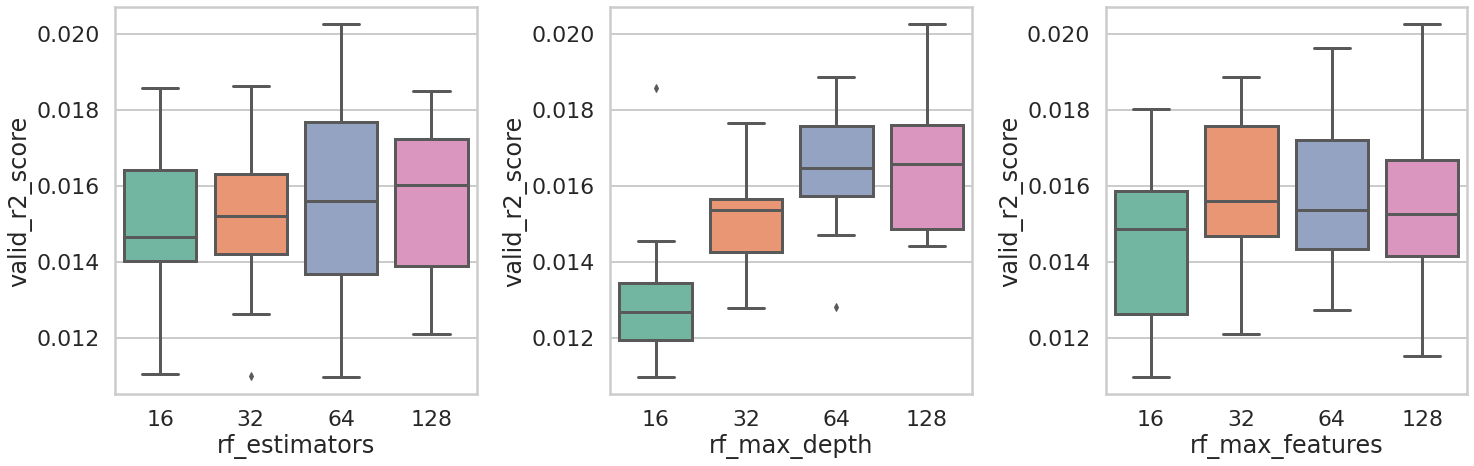

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.boxplot(data=perf_df, x="rf_estimators", y="valid_r2_score", ax=ax[0])
sns.boxplot(data=perf_df, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
sns.boxplot(data=perf_df, x="rf_max_features", y="valid_r2_score", ax=ax[2])
fig.tight_layout()

### Random search

In [ ]:
rfe_list = []
rfd_list = []
rff_list = []
valid_auc_list = []

num_trials = 50

for i in range(num_trials):
    params["rf_estimators"] = np.random.randint(8,256)
    params["rf_max_depth"] = np.random.randint(8,256)
    params["rf_max_features"] = np.random.randint(8,256)
    rfe_list.append(params["rf_estimators"])
    rfd_list.append(params["rf_max_depth"])
    rff_list.append(params["rf_max_features"])
    tp = parse.wrapper(params)
    pl = mp.ModelPipeline(tp)
    pl.train_model()
    pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
    pred_results = pred_data.get_prediction_results()
    valid_auc = pred_results['roc_auc_score']
    valid_auc_list.append(valid_auc)
    print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_auc: {valid_auc}")

number of features: 1024


2021-04-01 20:59:08,423 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.668 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 20:59:36,858 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/4e14e3fb-d01d-41eb-add3-74b71a697328/model_metadata.json
2021-04-01 20:59:37,924 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/4e14e3fb-d01d-41eb-add3-74b71a697328/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_4e14e3fb-d01d-41eb-add3-74b71a697328.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.017170913091746676
number of features: 1024


2021-04-01 21:00:54,231 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.679 s
Loading dataset from disk.
TIMING: dataset construction took 0.090 s
Loading dataset from disk.
TIMING: dataset construction took 0.090 s
Loading dataset from disk.


2021-04-01 21:01:10,732 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/ed48c12e-ab20-407d-bc85-fe63fb418ce0/model_metadata.json
2021-04-01 21:01:11,448 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/ed48c12e-ab20-407d-bc85-fe63fb418ce0/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_ed48c12e-ab20-407d-bc85-fe63fb418ce0.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.017540606071390186
number of features: 1024


2021-04-01 21:02:27,025 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.660 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 21:03:04,411 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/192ac092-9d5e-4c59-bfc7-8a97dd58c35b/model_metadata.json
2021-04-01 21:03:06,260 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/192ac092-9d5e-4c59-bfc7-8a97dd58c35b/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_192ac092-9d5e-4c59-bfc7-8a97dd58c35b.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.015945719744887565
number of features: 1024


2021-04-01 21:04:22,580 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.706 s
Loading dataset from disk.
TIMING: dataset construction took 0.096 s
Loading dataset from disk.
TIMING: dataset construction took 0.094 s
Loading dataset from disk.


2021-04-01 21:04:49,104 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/caa41b0c-49de-4119-b065-b8c7452d0041/model_metadata.json
2021-04-01 21:04:49,836 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/caa41b0c-49de-4119-b065-b8c7452d0041/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_caa41b0c-49de-4119-b065-b8c7452d0041.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.01720113314142191
number of features: 1024


2021-04-01 21:06:05,990 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.677 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.


2021-04-01 21:06:41,980 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/3f0ff6ad-e47b-4fb6-be8f-9dc400e8fd78/model_metadata.json
2021-04-01 21:06:42,788 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/3f0ff6ad-e47b-4fb6-be8f-9dc400e8fd78/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_3f0ff6ad-e47b-4fb6-be8f-9dc400e8fd78.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.0164886568901621
number of features: 1024


2021-04-01 21:07:58,644 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.673 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.


2021-04-01 21:08:19,223 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/2b430052-70cf-4932-a16e-9196ea034184/model_metadata.json
2021-04-01 21:08:20,454 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/2b430052-70cf-4932-a16e-9196ea034184/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_2b430052-70cf-4932-a16e-9196ea034184.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.016659544835595286
number of features: 1024


2021-04-01 21:09:36,018 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.661 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 21:09:46,259 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/6a9b2732-ee23-45ae-b0b8-9f96ff5930b5/model_metadata.json
2021-04-01 21:09:46,304 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/6a9b2732-ee23-45ae-b0b8-9f96ff5930b5/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_6a9b2732-ee23-45ae-b0b8-9f96ff5930b5.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.010193783530930811
number of features: 1024


2021-04-01 21:11:02,284 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.662 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
TIMING: dataset construction took 0.090 s
Loading dataset from disk.


2021-04-01 21:11:27,354 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/be94f6a6-edd4-4486-8214-924433dc44cc/model_metadata.json
2021-04-01 21:11:29,584 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/be94f6a6-edd4-4486-8214-924433dc44cc/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_be94f6a6-edd4-4486-8214-924433dc44cc.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.0165717139309155
number of features: 1024


2021-04-01 21:12:45,278 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.662 s
Loading dataset from disk.
TIMING: dataset construction took 0.090 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.


2021-04-01 21:13:39,306 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/d96edd15-7300-43bb-a67c-31bd1611fd0d/model_metadata.json
2021-04-01 21:13:41,138 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/d96edd15-7300-43bb-a67c-31bd1611fd0d/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_d96edd15-7300-43bb-a67c-31bd1611fd0d.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.017222005722753786
number of features: 1024


2021-04-01 21:14:57,138 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.661 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 21:15:10,447 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/675428c0-78f8-4be8-b927-2e637ca2f2bc/model_metadata.json
2021-04-01 21:15:11,329 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/675428c0-78f8-4be8-b927-2e637ca2f2bc/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_675428c0-78f8-4be8-b927-2e637ca2f2bc.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.015732696897510112
number of features: 1024


2021-04-01 21:16:27,487 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.652 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 21:16:55,541 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/c6455a6a-9b68-4226-bddc-ba2a405dac59/model_metadata.json
2021-04-01 21:16:57,214 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/c6455a6a-9b68-4226-bddc-ba2a405dac59/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_c6455a6a-9b68-4226-bddc-ba2a405dac59.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.017457490639124607
number of features: 1024


2021-04-01 21:18:12,987 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.667 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 21:18:25,391 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/66a4626f-359c-4b8f-87bb-348cb5b9c636/model_metadata.json
2021-04-01 21:18:25,678 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/66a4626f-359c-4b8f-87bb-348cb5b9c636/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_66a4626f-359c-4b8f-87bb-348cb5b9c636.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.01873191645167449
number of features: 1024


2021-04-01 21:19:41,451 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.653 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.


2021-04-01 21:20:29,265 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/8c53bf36-87e8-4383-8fea-8b727ae3fd00/model_metadata.json
2021-04-01 21:20:30,977 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/8c53bf36-87e8-4383-8fea-8b727ae3fd00/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_8c53bf36-87e8-4383-8fea-8b727ae3fd00.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.016846341020572808
number of features: 1024


2021-04-01 21:21:46,438 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.659 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.


2021-04-01 21:22:01,254 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/f0d66246-bc07-4698-921f-eaae3a4ab9fd/model_metadata.json
2021-04-01 21:22:03,807 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/f0d66246-bc07-4698-921f-eaae3a4ab9fd/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_f0d66246-bc07-4698-921f-eaae3a4ab9fd.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.017291450639489447
number of features: 1024


2021-04-01 21:23:19,314 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.658 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 21:24:13,482 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/36c85018-d1cc-4b39-91ef-99ff20128275/model_metadata.json
2021-04-01 21:24:15,560 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/36c85018-d1cc-4b39-91ef-99ff20128275/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_36c85018-d1cc-4b39-91ef-99ff20128275.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.017025215287365558
number of features: 1024


2021-04-01 21:25:30,920 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.665 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 21:26:12,712 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/f87e7361-c8f0-4cfb-9f1a-b3cffbdc982b/model_metadata.json
2021-04-01 21:26:14,246 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/f87e7361-c8f0-4cfb-9f1a-b3cffbdc982b/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_f87e7361-c8f0-4cfb-9f1a-b3cffbdc982b.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.017663850942516768
number of features: 1024


2021-04-01 21:27:29,738 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.675 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 21:28:04,609 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/f322d4a8-62a0-46d9-8ee9-235fde47d587/model_metadata.json
2021-04-01 21:28:05,099 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/f322d4a8-62a0-46d9-8ee9-235fde47d587/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_f322d4a8-62a0-46d9-8ee9-235fde47d587.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.01417242698051624
number of features: 1024


2021-04-01 21:29:20,546 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.674 s
Loading dataset from disk.
TIMING: dataset construction took 0.090 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.


2021-04-01 21:29:33,345 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/7834500d-b34a-431b-834d-4f845c12c51c/model_metadata.json
2021-04-01 21:29:34,371 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/7834500d-b34a-431b-834d-4f845c12c51c/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_7834500d-b34a-431b-834d-4f845c12c51c.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.01579939013791931
number of features: 1024


2021-04-01 21:30:49,913 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.673 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.


2021-04-01 21:31:08,404 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/c616f96a-16a4-46dc-8a76-cdbdcbf4809b/model_metadata.json
2021-04-01 21:31:09,407 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/c616f96a-16a4-46dc-8a76-cdbdcbf4809b/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_c616f96a-16a4-46dc-8a76-cdbdcbf4809b.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.01738540199614358
number of features: 1024


2021-04-01 21:32:24,995 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.688 s
Loading dataset from disk.
TIMING: dataset construction took 0.091 s
Loading dataset from disk.
TIMING: dataset construction took 0.093 s
Loading dataset from disk.


2021-04-01 21:32:41,869 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/bd5acfdc-ee94-4c03-a516-7f2ceea4a18c/model_metadata.json
2021-04-01 21:32:42,486 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/bd5acfdc-ee94-4c03-a516-7f2ceea4a18c/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_bd5acfdc-ee94-4c03-a516-7f2ceea4a18c.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.016159390644223892
number of features: 1024


2021-04-01 21:33:57,877 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.661 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 21:34:14,734 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/214011c2-9ab5-4440-9b79-03818ac24eec/model_metadata.json
2021-04-01 21:34:15,561 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/214011c2-9ab5-4440-9b79-03818ac24eec/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_214011c2-9ab5-4440-9b79-03818ac24eec.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.01765468280042848
number of features: 1024


2021-04-01 21:35:31,125 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.661 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 21:35:38,788 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/cf1430c6-578e-44ba-8abf-3bc8ebf87aef/model_metadata.json
2021-04-01 21:35:39,525 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/cf1430c6-578e-44ba-8abf-3bc8ebf87aef/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_cf1430c6-578e-44ba-8abf-3bc8ebf87aef.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.015360812097494958
number of features: 1024


2021-04-01 21:36:55,337 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.679 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.


2021-04-01 21:37:27,603 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/67a7a6f2-d29a-499f-a291-74d158320590/model_metadata.json
2021-04-01 21:37:29,958 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/67a7a6f2-d29a-499f-a291-74d158320590/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_67a7a6f2-d29a-499f-a291-74d158320590.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.01700897437287119
number of features: 1024


2021-04-01 21:38:45,423 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.667 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.


2021-04-01 21:38:53,755 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/073a5e27-ff3c-4882-8ca5-ae108ec5ae96/model_metadata.json
2021-04-01 21:38:53,920 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/073a5e27-ff3c-4882-8ca5-ae108ec5ae96/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_073a5e27-ff3c-4882-8ca5-ae108ec5ae96.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.018600583410159244
number of features: 1024


2021-04-01 21:40:09,721 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.662 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.


2021-04-01 21:40:57,650 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/9b7f852e-9f61-42e1-9eaf-d116da8393f2/model_metadata.json
2021-04-01 21:40:59,013 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/9b7f852e-9f61-42e1-9eaf-d116da8393f2/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_9b7f852e-9f61-42e1-9eaf-d116da8393f2.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.016557937763571506
number of features: 1024


2021-04-01 21:42:14,864 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.668 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 21:42:46,162 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/800571ae-adb4-4880-975f-a1d897177cea/model_metadata.json
2021-04-01 21:42:48,134 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/800571ae-adb4-4880-975f-a1d897177cea/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_800571ae-adb4-4880-975f-a1d897177cea.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.016859669364341023
number of features: 1024


2021-04-01 21:44:03,910 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.662 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 21:44:44,179 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/dc818d2b-1223-443b-8681-d94753a3d194/model_metadata.json
2021-04-01 21:44:45,352 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/dc818d2b-1223-443b-8681-d94753a3d194/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_dc818d2b-1223-443b-8681-d94753a3d194.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.017968192526624294
number of features: 1024


2021-04-01 21:46:00,884 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.668 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.


2021-04-01 21:46:53,796 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/dec14196-d794-4945-8497-63cc079ed74d/model_metadata.json
2021-04-01 21:46:55,718 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/dec14196-d794-4945-8497-63cc079ed74d/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_dec14196-d794-4945-8497-63cc079ed74d.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.01896125723318487
number of features: 1024


2021-04-01 21:48:11,273 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.667 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.


2021-04-01 21:48:28,701 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/cef75c03-7c46-4e9e-a749-4e48b2aaa192/model_metadata.json
2021-04-01 21:48:30,246 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/cef75c03-7c46-4e9e-a749-4e48b2aaa192/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_cef75c03-7c46-4e9e-a749-4e48b2aaa192.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.017575990589876356
number of features: 1024


2021-04-01 21:49:45,810 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.660 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 21:50:10,938 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/9f1d20c0-5647-4e9c-850b-7c91fb50897f/model_metadata.json
2021-04-01 21:50:13,227 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/9f1d20c0-5647-4e9c-850b-7c91fb50897f/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_9f1d20c0-5647-4e9c-850b-7c91fb50897f.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.016865097111285365
number of features: 1024


2021-04-01 21:51:29,001 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.670 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
TIMING: dataset construction took 0.091 s
Loading dataset from disk.


2021-04-01 21:51:41,098 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/25fb37a4-dabe-42fe-8b41-bb6506db8f7c/model_metadata.json
2021-04-01 21:51:42,396 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/25fb37a4-dabe-42fe-8b41-bb6506db8f7c/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_25fb37a4-dabe-42fe-8b41-bb6506db8f7c.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.017144527408341603
number of features: 1024


2021-04-01 21:52:58,287 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.666 s
Loading dataset from disk.
TIMING: dataset construction took 0.091 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.


2021-04-01 21:53:05,928 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/12cf60cf-865a-462b-aaf1-3fc1215af064/model_metadata.json
2021-04-01 21:53:06,435 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/12cf60cf-865a-462b-aaf1-3fc1215af064/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_12cf60cf-865a-462b-aaf1-3fc1215af064.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.018357189861050727
number of features: 1024


2021-04-01 21:54:21,867 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.667 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 21:54:47,675 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/82e9f7c1-cfc2-4cf9-8cfa-029e059bd10d/model_metadata.json
2021-04-01 21:54:48,675 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/82e9f7c1-cfc2-4cf9-8cfa-029e059bd10d/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_82e9f7c1-cfc2-4cf9-8cfa-029e059bd10d.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.017545147823447738
number of features: 1024


2021-04-01 21:56:04,438 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.659 s
Loading dataset from disk.
TIMING: dataset construction took 0.090 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.


2021-04-01 21:56:42,490 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/f31b6164-c4af-4245-87b6-b367a2899a7d/model_metadata.json
2021-04-01 21:56:43,912 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/f31b6164-c4af-4245-87b6-b367a2899a7d/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_f31b6164-c4af-4245-87b6-b367a2899a7d.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.018164512454204473
number of features: 1024


2021-04-01 21:57:59,683 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.659 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 21:58:21,440 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/b602bfb9-4190-4001-9549-f1770822b72b/model_metadata.json
2021-04-01 21:58:23,590 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/b602bfb9-4190-4001-9549-f1770822b72b/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_b602bfb9-4190-4001-9549-f1770822b72b.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.01691586241324594
number of features: 1024


2021-04-01 21:59:39,139 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.671 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.


2021-04-01 22:00:05,382 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/6aafa49b-dcc9-41e1-b9db-c1c2f656b8c4/model_metadata.json
2021-04-01 22:00:07,867 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/6aafa49b-dcc9-41e1-b9db-c1c2f656b8c4/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_6aafa49b-dcc9-41e1-b9db-c1c2f656b8c4.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.016792872334578268
number of features: 1024


2021-04-01 22:01:23,788 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.670 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
TIMING: dataset construction took 0.090 s
Loading dataset from disk.


2021-04-01 22:01:44,494 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/89113ba1-fa92-479a-b2c1-c9ace950b5ed/model_metadata.json
2021-04-01 22:01:46,450 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/89113ba1-fa92-479a-b2c1-c9ace950b5ed/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_89113ba1-fa92-479a-b2c1-c9ace950b5ed.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.017259777027142098
number of features: 1024


2021-04-01 22:03:02,298 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.658 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 22:03:14,142 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/49c8dca1-161f-40c2-b456-186c09890680/model_metadata.json
2021-04-01 22:03:15,040 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/49c8dca1-161f-40c2-b456-186c09890680/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_49c8dca1-161f-40c2-b456-186c09890680.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.016086175312020723
number of features: 1024


2021-04-01 22:04:30,604 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.655 s
Loading dataset from disk.
TIMING: dataset construction took 0.090 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.


2021-04-01 22:04:45,323 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/d66d1d94-11b7-49e1-bedd-3894b93bdc9a/model_metadata.json
2021-04-01 22:04:46,536 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/d66d1d94-11b7-49e1-bedd-3894b93bdc9a/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_d66d1d94-11b7-49e1-bedd-3894b93bdc9a.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.018198414868559554
number of features: 1024


2021-04-01 22:06:02,167 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.662 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 22:06:09,457 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/8d3ad9f9-d191-4cf5-8788-fbd9fe4a833b/model_metadata.json
2021-04-01 22:06:09,709 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/8d3ad9f9-d191-4cf5-8788-fbd9fe4a833b/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_8d3ad9f9-d191-4cf5-8788-fbd9fe4a833b.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.021973661650190657
number of features: 1024


2021-04-01 22:07:25,224 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.658 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.


2021-04-01 22:07:45,150 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/0ea809fd-e8ef-4a82-ad38-2a6f54419351/model_metadata.json
2021-04-01 22:07:46,607 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/0ea809fd-e8ef-4a82-ad38-2a6f54419351/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_0ea809fd-e8ef-4a82-ad38-2a6f54419351.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.01653971679235189
number of features: 1024


2021-04-01 22:09:02,395 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.657 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.


2021-04-01 22:09:49,901 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/88980598-6296-4320-b134-9fb7e6caef76/model_metadata.json
2021-04-01 22:09:52,243 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/88980598-6296-4320-b134-9fb7e6caef76/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_88980598-6296-4320-b134-9fb7e6caef76.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.017720314036372198
number of features: 1024


2021-04-01 22:11:07,957 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.661 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.


2021-04-01 22:11:13,457 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/514363ca-f23b-499a-b185-f75c96427a6a/model_metadata.json
2021-04-01 22:11:13,506 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/514363ca-f23b-499a-b185-f75c96427a6a/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_514363ca-f23b-499a-b185-f75c96427a6a.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.010566653211912858
number of features: 1024


2021-04-01 22:12:29,103 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.656 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 22:12:47,620 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/be772d59-d8f1-49a3-b94f-8ce142d608f1/model_metadata.json
2021-04-01 22:12:47,956 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/be772d59-d8f1-49a3-b94f-8ce142d608f1/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_be772d59-d8f1-49a3-b94f-8ce142d608f1.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.014560713986218055
number of features: 1024


2021-04-01 22:14:03,824 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.727 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 22:14:28,239 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/915bcd17-6bcd-4619-81df-63f71a5ac3b2/model_metadata.json
2021-04-01 22:14:29,152 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/915bcd17-6bcd-4619-81df-63f71a5ac3b2/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_915bcd17-6bcd-4619-81df-63f71a5ac3b2.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.017618790033208875
number of features: 1024


2021-04-01 22:15:44,590 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.659 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.


2021-04-01 22:16:01,773 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/43621a6f-8459-40e8-89a2-6572c202f809/model_metadata.json
2021-04-01 22:16:01,963 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/43621a6f-8459-40e8-89a2-6572c202f809/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_43621a6f-8459-40e8-89a2-6572c202f809.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.014146908631295196
number of features: 1024


2021-04-01 22:17:17,313 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.655 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 22:17:56,490 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/cd23bbd0-6f22-4092-b9b7-7fd9b540ff2c/model_metadata.json
2021-04-01 22:17:57,874 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/cd23bbd0-6f22-4092-b9b7-7fd9b540ff2c/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_cd23bbd0-6f22-4092-b9b7-7fd9b540ff2c.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.017903814813814645
number of features: 1024


2021-04-01 22:19:13,509 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.656 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.


2021-04-01 22:19:21,974 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/005320c9-a354-4bb0-a473-090ac9a8b6a9/model_metadata.json
2021-04-01 22:19:22,260 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/005320c9-a354-4bb0-a473-090ac9a8b6a9/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_005320c9-a354-4bb0-a473-090ac9a8b6a9.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.019139945796135427
number of features: 1024


2021-04-01 22:20:37,709 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.657 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.


2021-04-01 22:21:10,597 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/596cc9f0-2448-43bd-bf04-b3ef9e84d80c/model_metadata.json
2021-04-01 22:21:11,570 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/596cc9f0-2448-43bd-bf04-b3ef9e84d80c/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_596cc9f0-2448-43bd-bf04-b3ef9e84d80c.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.016201285636549212
number of features: 1024


2021-04-01 22:22:27,120 Previous dataset split restored


n_cnt [18642.]
y_means [5.19196307]
y_stds [1.21382351]
TIMING: dataset construction took 0.663 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.


2021-04-01 22:22:37,010 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/ff2a4aba-3b41-4c56-b246-99c0d0f1676d/model_metadata.json
2021-04-01 22:22:37,681 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/ff2a4aba-3b41-4c56-b246-99c0d0f1676d/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_ff2a4aba-3b41-4c56-b246-99c0d0f1676d.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.013679121613869971


In [ ]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_auc_score": valid_auc_list})
perf_df.sort_values(by="valid_auc_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
39,25,157,68,0.021974
47,32,67,95,0.019140
27,196,238,249,0.018961
11,29,156,241,0.018732
23,33,32,120,0.018601
31,50,225,25,0.018357
38,123,196,56,0.018198
33,154,98,214,0.018165
26,164,48,246,0.017968
46,160,69,222,0.017904


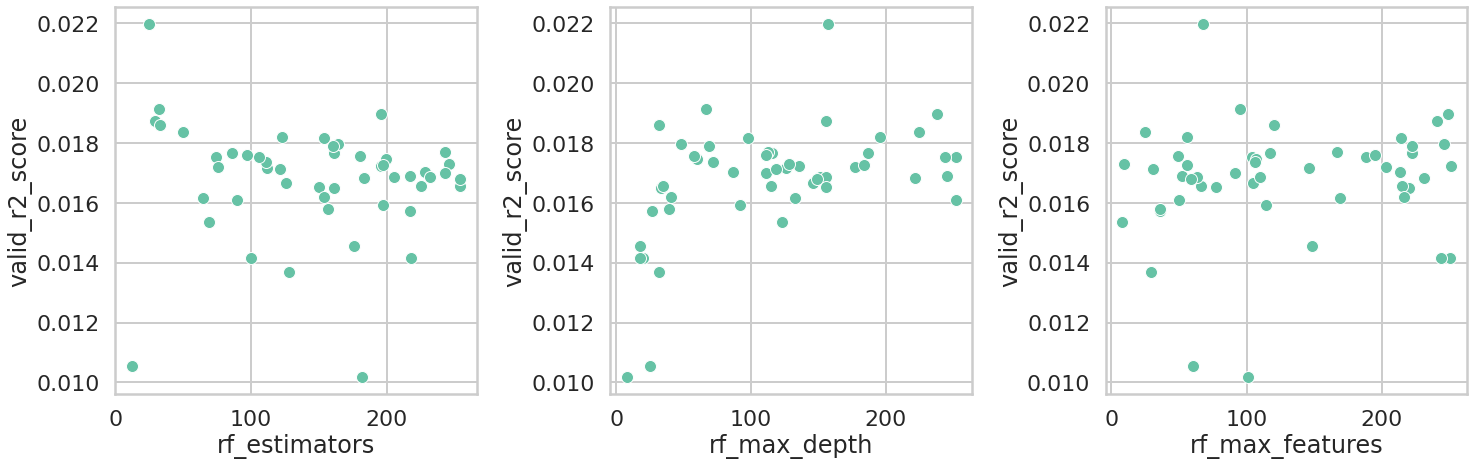

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.scatterplot(data=perf_df, x="rf_estimators", y="valid_auc_score", ax=ax[0])
sns.scatterplot(data=perf_df, x="rf_max_depth", y="valid_auc_score", ax=ax[1])
sns.scatterplot(data=perf_df, x="rf_max_features", y="valid_auc_score", ax=ax[2])
fig.tight_layout()

### Bayesian search

In [ ]:
#define loss function
def lossfn(p):
    params["rf_estimators"] = int(p["rf_estimator"])
    params["rf_max_depth"] = int(p["rf_depth"])
    params["rf_max_features"] = int(p["rf_feature"])
    
    tparam = parse.wrapper(params)
    pl = mp.ModelPipeline(tparam)
    pl.train_model()
    perf_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
    pred_results = perf_data.get_prediction_results()
    auc = pred_results['roc_auc_score']
    return {'loss': 1-auc, 
            'status': STATUS_OK, 
            'model': tparam.model_tarball_path, 
            'rf_estimator': params["rf_estimators"],
            'rf_depth': params["rf_max_depth"],
            'rf_feature': params["rf_max_features"]}

space = {
    "rf_estimator": hp.uniform("rf_estimator", 8, 256),
    "rf_depth": hp.uniform("rf_depth", 8, 256),
    "rf_feature": hp.uniform("rf_feature", 8, 256)
}

In [ ]:
trials = Trials()
best = fmin(lossfn, space, algo=tpe.suggest, max_evals=20, trials=trials)

number of features: 1024
  0%|          | 0/20 [01:11<?, ?it/s, best loss: ?]

2021-04-01 22:25:24,282 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.661 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
TIMING: dataset construction took 0.091 s
Loading dataset from disk.
  0%|          | 0/20 [01:17<?, ?it/s, best loss: ?]

2021-04-01 22:25:47,627 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/be0f71e6-a1a7-4e9c-b1be-438336c557fd/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_be0f71e6-a1a7-4e9c-b1be-438336c557fd.tar.gz
  0%|          | 0/20 [01:39<?, ?it/s, best loss: ?]

2021-04-01 22:25:48,276 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/be0f71e6-a1a7-4e9c-b1be-438336c557fd/model_metrics.json


number of features: 1024
  5%|▌         | 1/20 [02:50<31:36, 99.84s/it, best loss: 0.9830315736597234]

2021-04-01 22:27:04,049 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.676 s
Loading dataset from disk.
TIMING: dataset construction took 0.091 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
  5%|▌         | 1/20 [02:57<31:36, 99.84s/it, best loss: 0.9830315736597234]

2021-04-01 22:27:47,118 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/d21398fd-4ec1-46e8-b0b3-41b65beb7a1b/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_d21398fd-4ec1-46e8-b0b3-41b65beb7a1b.tar.gz
  5%|▌         | 1/20 [03:40<31:36, 99.84s/it, best loss: 0.9830315736597234]

2021-04-01 22:27:48,709 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/d21398fd-4ec1-46e8-b0b3-41b65beb7a1b/model_metrics.json


number of features: 1024
 10%|█         | 2/20 [04:51<31:48, 106.02s/it, best loss: 0.9830315736597234]

2021-04-01 22:29:04,428 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.660 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
 10%|█         | 2/20 [04:57<31:48, 106.02s/it, best loss: 0.9830315736597234]

2021-04-01 22:29:44,174 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/b4950c8a-9ee6-4879-8461-e7272a945396/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_b4950c8a-9ee6-4879-8461-e7272a945396.tar.gz
 10%|█         | 2/20 [05:38<31:48, 106.02s/it, best loss: 0.9830315736597234]

2021-04-01 22:29:46,458 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/b4950c8a-9ee6-4879-8461-e7272a945396/model_metrics.json


number of features: 1024
 15%|█▌        | 3/20 [06:49<31:02, 109.55s/it, best loss: 0.9830315736597234]

2021-04-01 22:31:02,325 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.664 s
Loading dataset from disk.
TIMING: dataset construction took 0.092 s
Loading dataset from disk.
TIMING: dataset construction took 0.093 s
Loading dataset from disk.
 15%|█▌        | 3/20 [06:55<31:02, 109.55s/it, best loss: 0.9830315736597234]

2021-04-01 22:31:09,524 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/e5738617-dd2a-4ca6-860d-526ee7af0f10/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_e5738617-dd2a-4ca6-860d-526ee7af0f10.tar.gz
 15%|█▌        | 3/20 [07:01<31:02, 109.55s/it, best loss: 0.9830315736597234]

2021-04-01 22:31:09,580 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/e5738617-dd2a-4ca6-860d-526ee7af0f10/model_metrics.json


number of features: 1024
 20%|██        | 4/20 [08:12<27:05, 101.60s/it, best loss: 0.9830315736597234]

2021-04-01 22:32:25,125 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.663 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.093 s
Loading dataset from disk.
 20%|██        | 4/20 [08:18<27:05, 101.60s/it, best loss: 0.9830315736597234]

2021-04-01 22:32:54,894 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/af8010a0-2467-4ff7-b9f0-98a8d40267e7/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_af8010a0-2467-4ff7-b9f0-98a8d40267e7.tar.gz
 20%|██        | 4/20 [08:47<27:05, 101.60s/it, best loss: 0.9830315736597234]

2021-04-01 22:32:55,977 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/af8010a0-2467-4ff7-b9f0-98a8d40267e7/model_metrics.json


number of features: 1024
 25%|██▌       | 5/20 [09:59<25:45, 103.04s/it, best loss: 0.9830315736597234]

2021-04-01 22:34:12,063 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.656 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
 25%|██▌       | 5/20 [10:05<25:45, 103.04s/it, best loss: 0.9830315736597234]

2021-04-01 22:34:49,234 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/c0fbd212-e242-433f-b0ac-f46c26a519fe/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_c0fbd212-e242-433f-b0ac-f46c26a519fe.tar.gz
 25%|██▌       | 5/20 [10:42<25:45, 103.04s/it, best loss: 0.9830315736597234]

2021-04-01 22:34:50,615 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/c0fbd212-e242-433f-b0ac-f46c26a519fe/model_metrics.json


number of features: 1024
 30%|███       | 6/20 [11:53<24:51, 106.52s/it, best loss: 0.9814497066360043]

2021-04-01 22:36:06,744 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.647 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
 30%|███       | 6/20 [11:59<24:51, 106.52s/it, best loss: 0.9814497066360043]

2021-04-01 22:36:15,594 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/60a2211f-78b5-413d-875e-544c0c2e8c32/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_60a2211f-78b5-413d-875e-544c0c2e8c32.tar.gz
 30%|███       | 6/20 [12:07<24:51, 106.52s/it, best loss: 0.9814497066360043]

2021-04-01 22:36:16,050 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/60a2211f-78b5-413d-875e-544c0c2e8c32/model_metrics.json


number of features: 1024
 35%|███▌      | 7/20 [13:18<21:42, 100.19s/it, best loss: 0.9814497066360043]

2021-04-01 22:37:31,810 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.650 s
Loading dataset from disk.
TIMING: dataset construction took 0.085 s
Loading dataset from disk.
TIMING: dataset construction took 0.085 s
Loading dataset from disk.
 35%|███▌      | 7/20 [13:24<21:42, 100.19s/it, best loss: 0.9814497066360043]

2021-04-01 22:38:05,145 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/5f1e7734-c44e-4431-a5d5-cb3f0b140d5b/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_5f1e7734-c44e-4431-a5d5-cb3f0b140d5b.tar.gz
 35%|███▌      | 7/20 [13:58<21:42, 100.19s/it, best loss: 0.9814497066360043]

2021-04-01 22:38:06,501 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/5f1e7734-c44e-4431-a5d5-cb3f0b140d5b/model_metrics.json


number of features: 1024
 40%|████      | 8/20 [15:09<20:39, 103.27s/it, best loss: 0.9814497066360043]

2021-04-01 22:39:22,023 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.650 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
 40%|████      | 8/20 [15:14<20:39, 103.27s/it, best loss: 0.9814497066360043]

2021-04-01 22:40:00,464 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/08bc9e30-56f6-4c39-8b82-a5c5534fba14/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_08bc9e30-56f6-4c39-8b82-a5c5534fba14.tar.gz
 40%|████      | 8/20 [15:54<20:39, 103.27s/it, best loss: 0.9814497066360043]

2021-04-01 22:40:02,848 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/08bc9e30-56f6-4c39-8b82-a5c5534fba14/model_metrics.json


number of features: 1024
 45%|████▌     | 9/20 [17:05<19:39, 107.22s/it, best loss: 0.9814497066360043]

2021-04-01 22:41:18,842 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.655 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
 45%|████▌     | 9/20 [17:11<19:39, 107.22s/it, best loss: 0.9814497066360043]

2021-04-01 22:41:24,535 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/8f3424af-94af-4e37-8861-8903ae506ab7/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_8f3424af-94af-4e37-8861-8903ae506ab7.tar.gz
 45%|████▌     | 9/20 [17:16<19:39, 107.22s/it, best loss: 0.9814497066360043]

2021-04-01 22:41:24,651 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/8f3424af-94af-4e37-8861-8903ae506ab7/model_metrics.json


number of features: 1024
 50%|█████     | 10/20 [18:27<16:35, 99.57s/it, best loss: 0.9814497066360043]

2021-04-01 22:42:40,168 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.658 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
 50%|█████     | 10/20 [18:33<16:35, 99.57s/it, best loss: 0.9814497066360043]

2021-04-01 22:42:54,593 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/2edfc039-abc2-4a07-924d-cd0e20f8ac04/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_2edfc039-abc2-4a07-924d-cd0e20f8ac04.tar.gz
 50%|█████     | 10/20 [18:47<16:35, 99.57s/it, best loss: 0.9814497066360043]

2021-04-01 22:42:55,992 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/2edfc039-abc2-4a07-924d-cd0e20f8ac04/model_metrics.json


number of features: 1024
 55%|█████▌    | 11/20 [19:58<14:33, 97.11s/it, best loss: 0.9814497066360043]

2021-04-01 22:44:11,801 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.647 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
 55%|█████▌    | 11/20 [20:04<14:33, 97.11s/it, best loss: 0.9814497066360043]

2021-04-01 22:44:24,363 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/0e7b85b4-f783-47d1-9e77-87d8e6ce72cc/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_0e7b85b4-f783-47d1-9e77-87d8e6ce72cc.tar.gz
 55%|█████▌    | 11/20 [20:17<14:33, 97.11s/it, best loss: 0.9814497066360043]

2021-04-01 22:44:25,536 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/0e7b85b4-f783-47d1-9e77-87d8e6ce72cc/model_metrics.json


number of features: 1024
 60%|██████    | 12/20 [21:28<12:38, 94.84s/it, best loss: 0.9814497066360043]

2021-04-01 22:45:41,192 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.678 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.090 s
Loading dataset from disk.
 60%|██████    | 12/20 [21:34<12:38, 94.84s/it, best loss: 0.9814497066360043]

2021-04-01 22:46:05,128 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/08c8d2dd-cd40-429b-8a5f-c71790c7ee67/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_08c8d2dd-cd40-429b-8a5f-c71790c7ee67.tar.gz
 60%|██████    | 12/20 [21:57<12:38, 94.84s/it, best loss: 0.9814497066360043]

2021-04-01 22:46:05,700 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/08c8d2dd-cd40-429b-8a5f-c71790c7ee67/model_metrics.json


number of features: 1024
 65%|██████▌   | 13/20 [23:08<11:15, 96.43s/it, best loss: 0.9814497066360043]

2021-04-01 22:47:21,352 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.651 s
Loading dataset from disk.
TIMING: dataset construction took 0.093 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
 65%|██████▌   | 13/20 [23:14<11:15, 96.43s/it, best loss: 0.9814497066360043]

2021-04-01 22:47:59,169 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/6b4f45f3-97a1-4e60-bca8-e629d555f70b/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_6b4f45f3-97a1-4e60-bca8-e629d555f70b.tar.gz
 65%|██████▌   | 13/20 [23:51<11:15, 96.43s/it, best loss: 0.9814497066360043]

2021-04-01 22:48:00,387 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/6b4f45f3-97a1-4e60-bca8-e629d555f70b/model_metrics.json


number of features: 1024
 70%|███████   | 14/20 [25:03<10:11, 101.91s/it, best loss: 0.9814497066360043]

2021-04-01 22:49:16,200 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.656 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
 70%|███████   | 14/20 [25:09<10:11, 101.91s/it, best loss: 0.9814497066360043]

2021-04-01 22:49:27,755 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/6956f770-8135-49eb-90d6-e3342bc2eb7f/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_6956f770-8135-49eb-90d6-e3342bc2eb7f.tar.gz
 70%|███████   | 14/20 [25:20<10:11, 101.91s/it, best loss: 0.9814497066360043]

2021-04-01 22:49:28,796 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/6956f770-8135-49eb-90d6-e3342bc2eb7f/model_metrics.json


number of features: 1024
 75%|███████▌  | 15/20 [26:31<08:09, 97.86s/it, best loss: 0.9814497066360043]

2021-04-01 22:50:44,415 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.658 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
 75%|███████▌  | 15/20 [26:37<08:09, 97.86s/it, best loss: 0.9814497066360043]

2021-04-01 22:51:17,133 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/6d8e9e3b-eb2f-4788-ac18-e07ddb991ece/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_6d8e9e3b-eb2f-4788-ac18-e07ddb991ece.tar.gz
 75%|███████▌  | 15/20 [27:10<08:09, 97.86s/it, best loss: 0.9814497066360043]

2021-04-01 22:51:19,084 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/6d8e9e3b-eb2f-4788-ac18-e07ddb991ece/model_metrics.json


number of features: 1024
 80%|████████  | 16/20 [28:21<06:46, 101.60s/it, best loss: 0.9814497066360043]

2021-04-01 22:52:34,502 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.657 s
Loading dataset from disk.
TIMING: dataset construction took 0.090 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
 80%|████████  | 16/20 [28:27<06:46, 101.60s/it, best loss: 0.9814497066360043]

2021-04-01 22:52:52,652 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/00b92abc-7df2-45bd-ba1e-3eca5c90132b/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_00b92abc-7df2-45bd-ba1e-3eca5c90132b.tar.gz
 80%|████████  | 16/20 [28:46<06:46, 101.60s/it, best loss: 0.9814497066360043]

2021-04-01 22:52:54,840 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/00b92abc-7df2-45bd-ba1e-3eca5c90132b/model_metrics.json


number of features: 1024
 85%|████████▌ | 17/20 [29:57<04:59, 99.84s/it, best loss: 0.9814497066360043]

2021-04-01 22:54:10,509 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.653 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.092 s
Loading dataset from disk.
 85%|████████▌ | 17/20 [30:03<04:59, 99.84s/it, best loss: 0.9814497066360043]

2021-04-01 22:54:25,388 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/68247bbd-0ecd-4f19-af04-04a88d53040f/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_68247bbd-0ecd-4f19-af04-04a88d53040f.tar.gz
 85%|████████▌ | 17/20 [30:17<04:59, 99.84s/it, best loss: 0.9814497066360043]

2021-04-01 22:54:26,075 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/68247bbd-0ecd-4f19-af04-04a88d53040f/model_metrics.json


number of features: 1024
 90%|█████████ | 18/20 [31:28<03:14, 97.25s/it, best loss: 0.9814497066360043]

2021-04-01 22:55:41,730 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.649 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
 90%|█████████ | 18/20 [31:34<03:14, 97.25s/it, best loss: 0.9814497066360043]

2021-04-01 22:56:00,792 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/646537e5-3544-4292-b8f5-6fe82257c311/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_646537e5-3544-4292-b8f5-6fe82257c311.tar.gz
 90%|█████████ | 18/20 [31:53<03:14, 97.25s/it, best loss: 0.9814497066360043]

2021-04-01 22:56:02,005 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/646537e5-3544-4292-b8f5-6fe82257c311/model_metrics.json


number of features: 1024
 95%|█████████▌| 19/20 [33:04<01:36, 96.85s/it, best loss: 0.9814497066360043]

2021-04-01 22:57:17,253 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.655 s
Loading dataset from disk.
TIMING: dataset construction took 0.084 s
Loading dataset from disk.
TIMING: dataset construction took 0.085 s
Loading dataset from disk.
 95%|█████████▌| 19/20 [33:10<01:36, 96.85s/it, best loss: 0.9814497066360043]

2021-04-01 22:57:27,100 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/65a788c8-ef4a-4816-a856-5e4fed4eeb4c/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_65a788c8-ef4a-4816-a856-5e4fed4eeb4c.tar.gz
 95%|█████████▌| 19/20 [33:19<01:36, 96.85s/it, best loss: 0.9814497066360043]

2021-04-01 22:57:27,878 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/65a788c8-ef4a-4816-a856-5e4fed4eeb4c/model_metrics.json


100%|██████████| 20/20 [33:19<00:00, 99.97s/it, best loss: 0.9814497066360043]


(0.2, 0.6)

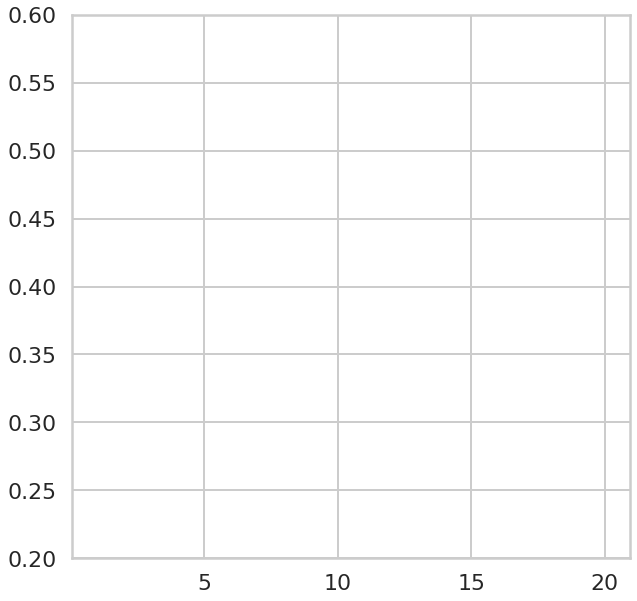

In [ ]:
r2_list = [1-trials.trials[i]["result"]["loss"] for i in range(len(trials.trials))]
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.lineplot(x=list(range(1,len(trials.trials)+1)), y=r2_list, ax=ax)
ax.set_ylim(0.2,0.6)

In [ ]:
rfe_list = [trials.trials[i]["result"]["rf_estimator"] for i in range(len(trials.trials))]
rfd_list = [trials.trials[i]["result"]["rf_depth"] for i in range(len(trials.trials))]
rff_list = [trials.trials[i]["result"]["rf_feature"] for i in range(len(trials.trials))]

In [ ]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_auc_score": auc_list})
perf_df.sort_values(by="valid_auc_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
5,147,232,220,0.018550
15,213,75,115,0.017457
11,118,93,38,0.017258
10,140,92,40,0.017161
16,220,97,32,0.017096
12,123,31,208,0.016971
0,114,37,200,0.016968
7,143,239,192,0.016953
18,120,94,97,0.016913
3,20,19,201,0.016819


#### Save Bayesian optimization trial object and continue later

In [ ]:
# save the trial object
trial_file = os.path.join("hp_trial.pkl")
with open(trial_file, "wb") as f:
    pickle.dump(trials, f)

In [ ]:
# load the trial object
with open(trial_file, "rb") as f:
    new_trials = pickle.load(f)

In [ ]:
# continue HPO
best = fmin(lossfn, space, algo=tpe.suggest, max_evals=50, trials=new_trials)

number of features: 1024
  0%|          | 0/30 [01:11<?, ?it/s, best loss: ?]

2021-04-01 23:06:50,464 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.651 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
  0%|          | 0/30 [01:17<?, ?it/s, best loss: ?]

2021-04-01 23:07:28,605 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/842cfc54-6c15-4a46-b815-17926e515164/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_842cfc54-6c15-4a46-b815-17926e515164.tar.gz
  0%|          | 0/30 [01:55<?, ?it/s, best loss: ?]

2021-04-01 23:07:30,478 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/842cfc54-6c15-4a46-b815-17926e515164/model_metrics.json


number of features: 1024
  3%|▎         | 1/30 [03:06<55:58, 115.82s/it, best loss: 0.9814497066360043]

2021-04-01 23:08:45,973 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.677 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
TIMING: dataset construction took 0.090 s
Loading dataset from disk.
  3%|▎         | 1/30 [03:12<55:58, 115.82s/it, best loss: 0.9814497066360043]

2021-04-01 23:09:23,022 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/53c7c1de-2571-4ffc-921e-09cf3811beb6/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_53c7c1de-2571-4ffc-921e-09cf3811beb6.tar.gz
  3%|▎         | 1/30 [03:50<55:58, 115.82s/it, best loss: 0.9814497066360043]

2021-04-01 23:09:24,724 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/53c7c1de-2571-4ffc-921e-09cf3811beb6/model_metrics.json


number of features: 1024
  7%|▋         | 2/30 [05:01<53:49, 115.34s/it, best loss: 0.9814497066360043]

2021-04-01 23:10:40,381 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.650 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.084 s
Loading dataset from disk.
  7%|▋         | 2/30 [05:07<53:49, 115.34s/it, best loss: 0.9814497066360043]

2021-04-01 23:11:18,188 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/d5fd236e-a74c-473e-b735-5c5757582f07/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_d5fd236e-a74c-473e-b735-5c5757582f07.tar.gz
  7%|▋         | 2/30 [05:45<53:49, 115.34s/it, best loss: 0.9814497066360043]

2021-04-01 23:11:19,887 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/d5fd236e-a74c-473e-b735-5c5757582f07/model_metrics.json


number of features: 1024
 10%|█         | 3/30 [06:56<51:52, 115.29s/it, best loss: 0.9814497066360043]

2021-04-01 23:12:35,524 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.703 s
Loading dataset from disk.
TIMING: dataset construction took 0.096 s
Loading dataset from disk.
TIMING: dataset construction took 0.099 s
Loading dataset from disk.
 10%|█         | 3/30 [07:02<51:52, 115.29s/it, best loss: 0.9814497066360043]

2021-04-01 23:13:21,740 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/8339ca4a-d73a-4b56-8693-5407c7c24434/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_8339ca4a-d73a-4b56-8693-5407c7c24434.tar.gz
 10%|█         | 3/30 [07:48<51:52, 115.29s/it, best loss: 0.9814497066360043]

2021-04-01 23:13:23,276 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/8339ca4a-d73a-4b56-8693-5407c7c24434/model_metrics.json


number of features: 1024
 13%|█▎        | 4/30 [08:59<51:00, 117.72s/it, best loss: 0.9814497066360043]

2021-04-01 23:14:38,596 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.645 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.085 s
Loading dataset from disk.
 13%|█▎        | 4/30 [09:05<51:00, 117.72s/it, best loss: 0.9814497066360043]

2021-04-01 23:15:18,591 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/387cd2f5-db2a-4649-8bf3-5aeee3475a87/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_387cd2f5-db2a-4649-8bf3-5aeee3475a87.tar.gz
 13%|█▎        | 4/30 [09:45<51:00, 117.72s/it, best loss: 0.9814497066360043]

2021-04-01 23:15:20,460 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/387cd2f5-db2a-4649-8bf3-5aeee3475a87/model_metrics.json


number of features: 1024
 17%|█▋        | 5/30 [10:57<48:59, 117.56s/it, best loss: 0.9814497066360043]

2021-04-01 23:16:36,326 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.649 s
Loading dataset from disk.
TIMING: dataset construction took 0.085 s
Loading dataset from disk.
TIMING: dataset construction took 0.085 s
Loading dataset from disk.
 17%|█▋        | 5/30 [11:03<48:59, 117.56s/it, best loss: 0.9814497066360043]

2021-04-01 23:17:18,443 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/6efeba8d-ffaf-483e-a268-df640dbc081c/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_6efeba8d-ffaf-483e-a268-df640dbc081c.tar.gz
 17%|█▋        | 5/30 [11:45<48:59, 117.56s/it, best loss: 0.9814497066360043]

2021-04-01 23:17:19,924 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/6efeba8d-ffaf-483e-a268-df640dbc081c/model_metrics.json


number of features: 1024
 20%|██        | 6/30 [12:56<47:15, 118.13s/it, best loss: 0.9814497066360043]

2021-04-01 23:18:35,526 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.645 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.085 s
Loading dataset from disk.
 20%|██        | 6/30 [13:02<47:15, 118.13s/it, best loss: 0.9814497066360043]

2021-04-01 23:18:50,271 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/c58ade0a-b937-4e0b-bd21-0cd914d9575a/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_c58ade0a-b937-4e0b-bd21-0cd914d9575a.tar.gz
 20%|██        | 6/30 [13:16<47:15, 118.13s/it, best loss: 0.9814497066360043]

2021-04-01 23:18:51,170 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/c58ade0a-b937-4e0b-bd21-0cd914d9575a/model_metrics.json


number of features: 1024
 23%|██▎       | 7/30 [14:27<42:11, 110.06s/it, best loss: 0.9814497066360043]

2021-04-01 23:20:06,846 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.654 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
 23%|██▎       | 7/30 [14:33<42:11, 110.06s/it, best loss: 0.9814497066360043]

2021-04-01 23:20:52,857 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/cdf0d179-96ba-4b79-89fe-a0e44119ea50/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_cdf0d179-96ba-4b79-89fe-a0e44119ea50.tar.gz
 23%|██▎       | 7/30 [15:20<42:11, 110.06s/it, best loss: 0.9814497066360043]

2021-04-01 23:20:55,383 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/cdf0d179-96ba-4b79-89fe-a0e44119ea50/model_metrics.json


number of features: 1024
 27%|██▋       | 8/30 [16:32<41:55, 114.33s/it, best loss: 0.9814497066360043]

2021-04-01 23:22:11,301 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.639 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
 27%|██▋       | 8/30 [16:37<41:55, 114.33s/it, best loss: 0.9814497066360043]

2021-04-01 23:22:22,404 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/313297ab-aa73-4040-9122-620c8300bff0/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_313297ab-aa73-4040-9122-620c8300bff0.tar.gz
 27%|██▋       | 8/30 [16:48<41:55, 114.33s/it, best loss: 0.9814497066360043]

2021-04-01 23:22:22,768 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/313297ab-aa73-4040-9122-620c8300bff0/model_metrics.json


number of features: 1024
 30%|███       | 9/30 [17:59<37:10, 106.22s/it, best loss: 0.9814497066360043]

2021-04-01 23:23:38,436 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.661 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.090 s
Loading dataset from disk.
 30%|███       | 9/30 [18:05<37:10, 106.22s/it, best loss: 0.9814497066360043]

2021-04-01 23:24:32,714 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/12973a67-9622-46b4-aea8-23297a7d15bc/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_12973a67-9622-46b4-aea8-23297a7d15bc.tar.gz
 30%|███       | 9/30 [19:00<37:10, 106.22s/it, best loss: 0.9814497066360043]

2021-04-01 23:24:35,115 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/12973a67-9622-46b4-aea8-23297a7d15bc/model_metrics.json


number of features: 1024
 33%|███▎      | 10/30 [20:11<38:01, 114.08s/it, best loss: 0.9814497066360043]

2021-04-01 23:25:51,177 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.668 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
 33%|███▎      | 10/30 [20:17<38:01, 114.08s/it, best loss: 0.9814497066360043]

2021-04-01 23:26:04,822 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/beb55478-2bc7-4e60-84c3-71933ac90494/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_beb55478-2bc7-4e60-84c3-71933ac90494.tar.gz
 33%|███▎      | 10/30 [20:32<38:01, 114.08s/it, best loss: 0.9814497066360043]

2021-04-01 23:26:06,942 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/beb55478-2bc7-4e60-84c3-71933ac90494/model_metrics.json


number of features: 1024
 37%|███▋      | 11/30 [21:43<34:00, 107.40s/it, best loss: 0.9814497066360043]

2021-04-01 23:27:22,556 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.648 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
 37%|███▋      | 11/30 [21:49<34:00, 107.40s/it, best loss: 0.9814497066360043]

2021-04-01 23:28:19,314 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/de165dcd-5264-4bc5-a321-f98221a69634/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_de165dcd-5264-4bc5-a321-f98221a69634.tar.gz
 37%|███▋      | 11/30 [22:46<34:00, 107.40s/it, best loss: 0.9814497066360043]

2021-04-01 23:28:21,421 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/de165dcd-5264-4bc5-a321-f98221a69634/model_metrics.json


number of features: 1024
 40%|████      | 12/30 [23:57<34:39, 115.52s/it, best loss: 0.9814497066360043]

2021-04-01 23:29:36,851 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.642 s
Loading dataset from disk.
TIMING: dataset construction took 0.085 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
 40%|████      | 12/30 [24:03<34:39, 115.52s/it, best loss: 0.9814497066360043]

2021-04-01 23:30:12,756 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/69024f62-8741-4933-8e26-2f2bc7d518b1/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_69024f62-8741-4933-8e26-2f2bc7d518b1.tar.gz
 40%|████      | 12/30 [24:40<34:39, 115.52s/it, best loss: 0.9814497066360043]

2021-04-01 23:30:14,762 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/69024f62-8741-4933-8e26-2f2bc7d518b1/model_metrics.json


number of features: 1024
 43%|████▎     | 13/30 [25:51<32:32, 114.86s/it, best loss: 0.9814497066360043]

2021-04-01 23:31:30,666 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.642 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
 43%|████▎     | 13/30 [25:57<32:32, 114.86s/it, best loss: 0.9814497066360043]

2021-04-01 23:31:41,638 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/a4d0c4b7-3393-4499-8d45-db162e7fcb96/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_a4d0c4b7-3393-4499-8d45-db162e7fcb96.tar.gz
 43%|████▎     | 13/30 [26:07<32:32, 114.86s/it, best loss: 0.9814497066360043]

2021-04-01 23:31:42,167 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/a4d0c4b7-3393-4499-8d45-db162e7fcb96/model_metrics.json


number of features: 1024
 47%|████▋     | 14/30 [27:18<28:25, 106.62s/it, best loss: 0.9814497066360043]

2021-04-01 23:32:57,547 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.711 s
Loading dataset from disk.
TIMING: dataset construction took 0.096 s
Loading dataset from disk.
TIMING: dataset construction took 0.093 s
Loading dataset from disk.
 47%|████▋     | 14/30 [27:24<28:25, 106.62s/it, best loss: 0.9814497066360043]

2021-04-01 23:33:36,005 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/12716ace-3194-49ea-9353-594513a2fb64/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_12716ace-3194-49ea-9353-594513a2fb64.tar.gz
 47%|████▋     | 14/30 [28:02<28:25, 106.62s/it, best loss: 0.9814497066360043]

2021-04-01 23:33:37,448 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/12716ace-3194-49ea-9353-594513a2fb64/model_metrics.json


number of features: 1024
 50%|█████     | 15/30 [29:13<27:18, 109.22s/it, best loss: 0.9814497066360043]

2021-04-01 23:34:52,979 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.655 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
 50%|█████     | 15/30 [29:19<27:18, 109.22s/it, best loss: 0.9814497066360043]

2021-04-01 23:35:43,726 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/c3553c56-1bbc-4424-a351-52d81b8a3951/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_c3553c56-1bbc-4424-a351-52d81b8a3951.tar.gz
 50%|█████     | 15/30 [30:11<27:18, 109.22s/it, best loss: 0.9814497066360043]

2021-04-01 23:35:46,118 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/c3553c56-1bbc-4424-a351-52d81b8a3951/model_metrics.json


number of features: 1024
 53%|█████▎    | 16/30 [31:22<26:50, 115.07s/it, best loss: 0.9812628295397555]

2021-04-01 23:37:01,926 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.648 s
Loading dataset from disk.
TIMING: dataset construction took 0.096 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
 53%|█████▎    | 16/30 [31:28<26:50, 115.07s/it, best loss: 0.9812628295397555]

2021-04-01 23:38:02,717 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/6b725db8-d733-425d-a205-8fd7a1de2629/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_6b725db8-d733-425d-a205-8fd7a1de2629.tar.gz
 53%|█████▎    | 16/30 [32:30<26:50, 115.07s/it, best loss: 0.9812628295397555]

2021-04-01 23:38:04,975 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/6b725db8-d733-425d-a205-8fd7a1de2629/model_metrics.json


number of features: 1024
 57%|█████▋    | 17/30 [33:41<26:28, 122.21s/it, best loss: 0.9812628295397555]

2021-04-01 23:39:20,615 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.648 s
Loading dataset from disk.
TIMING: dataset construction took 0.084 s
Loading dataset from disk.
TIMING: dataset construction took 0.085 s
Loading dataset from disk.
 57%|█████▋    | 17/30 [33:47<26:28, 122.21s/it, best loss: 0.9812628295397555]

2021-04-01 23:39:49,279 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/d9221df8-15d6-4eb6-8b83-f10ca934d1bb/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_d9221df8-15d6-4eb6-8b83-f10ca934d1bb.tar.gz
 57%|█████▋    | 17/30 [34:15<26:28, 122.21s/it, best loss: 0.9812628295397555]

2021-04-01 23:39:50,280 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/d9221df8-15d6-4eb6-8b83-f10ca934d1bb/model_metrics.json


number of features: 1024
 60%|██████    | 18/30 [35:26<23:25, 117.12s/it, best loss: 0.9812628295397555]

2021-04-01 23:41:06,169 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.653 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
 60%|██████    | 18/30 [35:32<23:25, 117.12s/it, best loss: 0.9812628295397555]

2021-04-01 23:41:45,956 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/fc26d47c-74dc-44aa-9f3a-ec341dfabf6e/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_fc26d47c-74dc-44aa-9f3a-ec341dfabf6e.tar.gz
 60%|██████    | 18/30 [36:13<23:25, 117.12s/it, best loss: 0.9812628295397555]

2021-04-01 23:41:47,760 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/fc26d47c-74dc-44aa-9f3a-ec341dfabf6e/model_metrics.json


number of features: 1024
 63%|██████▎   | 19/30 [37:24<21:29, 117.23s/it, best loss: 0.9812628295397555]

2021-04-01 23:43:03,463 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.668 s
Loading dataset from disk.
TIMING: dataset construction took 0.101 s
Loading dataset from disk.
TIMING: dataset construction took 0.093 s
Loading dataset from disk.
 63%|██████▎   | 19/30 [37:30<21:29, 117.23s/it, best loss: 0.9812628295397555]

2021-04-01 23:43:40,800 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/f78909d2-c538-4839-8eac-d8d12672bb65/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_f78909d2-c538-4839-8eac-d8d12672bb65.tar.gz
 63%|██████▎   | 19/30 [38:07<21:29, 117.23s/it, best loss: 0.9812628295397555]

2021-04-01 23:43:42,201 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/f78909d2-c538-4839-8eac-d8d12672bb65/model_metrics.json


number of features: 1024
 67%|██████▋   | 20/30 [39:18<19:23, 116.39s/it, best loss: 0.9812628295397555]

2021-04-01 23:44:57,456 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.651 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
 67%|██████▋   | 20/30 [39:24<19:23, 116.39s/it, best loss: 0.9812628295397555]

2021-04-01 23:45:49,513 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/1e531937-e234-4a56-83e8-f8bd4338c218/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_1e531937-e234-4a56-83e8-f8bd4338c218.tar.gz
 67%|██████▋   | 20/30 [40:17<19:23, 116.39s/it, best loss: 0.9812628295397555]

2021-04-01 23:45:51,773 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/1e531937-e234-4a56-83e8-f8bd4338c218/model_metrics.json


number of features: 1024
 70%|███████   | 21/30 [41:28<18:03, 120.36s/it, best loss: 0.9812628295397555]

2021-04-01 23:47:07,786 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.643 s
Loading dataset from disk.
TIMING: dataset construction took 0.092 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
 70%|███████   | 21/30 [41:34<18:03, 120.36s/it, best loss: 0.9812628295397555]

2021-04-01 23:47:30,991 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/6b5cde50-232f-44ee-9d74-7136dab48e27/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_6b5cde50-232f-44ee-9d74-7136dab48e27.tar.gz
 70%|███████   | 21/30 [41:57<18:03, 120.36s/it, best loss: 0.9812628295397555]

2021-04-01 23:47:31,838 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/6b5cde50-232f-44ee-9d74-7136dab48e27/model_metrics.json


number of features: 1024
 73%|███████▎  | 22/30 [43:08<15:14, 114.26s/it, best loss: 0.9812628295397555]

2021-04-01 23:48:47,376 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.648 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
 73%|███████▎  | 22/30 [43:14<15:14, 114.26s/it, best loss: 0.9812628295397555]

2021-04-01 23:48:54,650 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/5807e0bf-ace3-44d3-a61d-569c8e83aace/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_5807e0bf-ace3-44d3-a61d-569c8e83aace.tar.gz
 73%|███████▎  | 22/30 [43:19<15:14, 114.26s/it, best loss: 0.9812628295397555]

2021-04-01 23:48:54,679 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/5807e0bf-ace3-44d3-a61d-569c8e83aace/model_metrics.json


number of features: 1024
 77%|███████▋  | 23/30 [44:31<12:13, 104.83s/it, best loss: 0.9812628295397555]

2021-04-01 23:50:10,332 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.639 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.085 s
Loading dataset from disk.
 77%|███████▋  | 23/30 [44:37<12:13, 104.83s/it, best loss: 0.9812628295397555]

2021-04-01 23:50:46,588 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/a34b9727-fdb3-4d0d-bcf1-0505bd4830de/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_a34b9727-fdb3-4d0d-bcf1-0505bd4830de.tar.gz
 77%|███████▋  | 23/30 [45:13<12:13, 104.83s/it, best loss: 0.9812628295397555]

2021-04-01 23:50:47,845 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/a34b9727-fdb3-4d0d-bcf1-0505bd4830de/model_metrics.json


number of features: 1024
 80%|████████  | 24/30 [46:24<10:43, 107.33s/it, best loss: 0.9812628295397555]

2021-04-01 23:52:03,597 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.655 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
 80%|████████  | 24/30 [46:30<10:43, 107.33s/it, best loss: 0.9812628295397555]

2021-04-01 23:52:34,949 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/125973fa-59fe-4c2e-89ef-cb8e05e687c8/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_125973fa-59fe-4c2e-89ef-cb8e05e687c8.tar.gz
 80%|████████  | 24/30 [47:02<10:43, 107.33s/it, best loss: 0.9812628295397555]

2021-04-01 23:52:36,931 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/125973fa-59fe-4c2e-89ef-cb8e05e687c8/model_metrics.json


number of features: 1024
 83%|████████▎ | 25/30 [48:13<08:59, 107.87s/it, best loss: 0.9812628295397555]

2021-04-01 23:53:52,802 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.674 s
Loading dataset from disk.
TIMING: dataset construction took 0.095 s
Loading dataset from disk.
TIMING: dataset construction took 0.098 s
Loading dataset from disk.
 83%|████████▎ | 25/30 [48:19<08:59, 107.87s/it, best loss: 0.9812628295397555]

2021-04-01 23:54:22,853 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/927df7ec-796a-4688-b08e-deff0d70aa2c/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_927df7ec-796a-4688-b08e-deff0d70aa2c.tar.gz
 83%|████████▎ | 25/30 [48:49<08:59, 107.87s/it, best loss: 0.9812628295397555]

2021-04-01 23:54:24,483 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/927df7ec-796a-4688-b08e-deff0d70aa2c/model_metrics.json


number of features: 1024
 87%|████████▋ | 26/30 [50:01<07:11, 107.77s/it, best loss: 0.9812628295397555]

2021-04-01 23:55:40,629 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.645 s
Loading dataset from disk.
TIMING: dataset construction took 0.085 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
 87%|████████▋ | 26/30 [50:07<07:11, 107.77s/it, best loss: 0.9812628295397555]

2021-04-01 23:56:25,508 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/2eec0bb9-997b-42a0-83be-3b5f79bbe72f/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_2eec0bb9-997b-42a0-83be-3b5f79bbe72f.tar.gz
 87%|████████▋ | 26/30 [50:52<07:11, 107.77s/it, best loss: 0.9812628295397555]

2021-04-01 23:56:27,276 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/2eec0bb9-997b-42a0-83be-3b5f79bbe72f/model_metrics.json


number of features: 1024
 90%|█████████ | 27/30 [52:04<05:36, 112.28s/it, best loss: 0.9812628295397555]

2021-04-01 23:57:43,401 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.643 s
Loading dataset from disk.
TIMING: dataset construction took 0.084 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
 90%|█████████ | 27/30 [52:10<05:36, 112.28s/it, best loss: 0.9812628295397555]

2021-04-01 23:58:09,073 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/21d52d2b-06ce-4656-bdb8-43425d5b4abd/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_21d52d2b-06ce-4656-bdb8-43425d5b4abd.tar.gz
 90%|█████████ | 27/30 [52:36<05:36, 112.28s/it, best loss: 0.9812628295397555]

2021-04-01 23:58:11,308 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/21d52d2b-06ce-4656-bdb8-43425d5b4abd/model_metrics.json


number of features: 1024
 93%|█████████▎| 28/30 [53:47<03:39, 109.80s/it, best loss: 0.9812628295397555]

2021-04-01 23:59:27,318 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.657 s
Loading dataset from disk.
TIMING: dataset construction took 0.090 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
 93%|█████████▎| 28/30 [53:54<03:39, 109.80s/it, best loss: 0.9812628295397555]

2021-04-01 23:59:48,746 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/528c809a-7f7b-4eaf-b0c6-96ab5837746b/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_528c809a-7f7b-4eaf-b0c6-96ab5837746b.tar.gz
 93%|█████████▎| 28/30 [54:14<03:39, 109.80s/it, best loss: 0.9812628295397555]

2021-04-01 23:59:49,362 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/528c809a-7f7b-4eaf-b0c6-96ab5837746b/model_metrics.json


number of features: 1024
 97%|█████████▋| 29/30 [55:26<01:46, 106.27s/it, best loss: 0.9812628295397555]

2021-04-02 00:01:05,716 Previous dataset split restored


n_cnt
[18642.]
y_means
[5.19196307]
y_stds
[1.21382351]
TIMING: dataset construction took 0.710 s
Loading dataset from disk.
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
 97%|█████████▋| 29/30 [55:32<01:46, 106.27s/it, best loss: 0.9812628295397555]

2021-04-02 00:01:12,267 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/c15923a5-48a6-4b85-88f7-5c7908402cbc/model_metadata.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_c15923a5-48a6-4b85-88f7-5c7908402cbc.tar.gz
 97%|█████████▋| 29/30 [55:37<01:46, 106.27s/it, best loss: 0.9812628295397555]

2021-04-02 00:01:12,350 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_regression/c15923a5-48a6-4b85-88f7-5c7908402cbc/model_metrics.json


100%|██████████| 30/30 [55:37<00:00, 111.26s/it, best loss: 0.9812628295397555]


(0.2, 0.6)

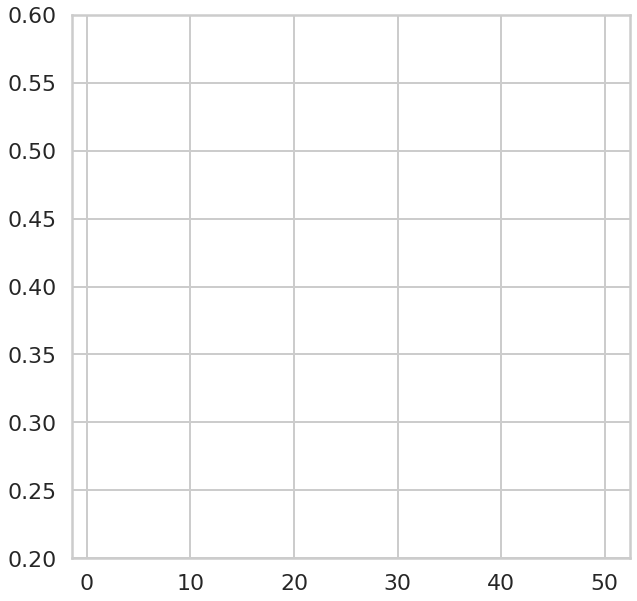

In [ ]:
auc_list = [1-new_trials.trials[i]["result"]["loss"] for i in range(len(new_trials.trials))]
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.lineplot(x=list(range(1,len(new_trials.trials)+1)), y=auc_list, ax=ax)
ax.set_ylim(0.2,0.6)

In [ ]:
rfe_list = [new_trials.trials[i]["result"]["rf_estimator"] for i in range(len(new_trials.trials))]
rfd_list = [new_trials.trials[i]["result"]["rf_depth"] for i in range(len(new_trials.trials))]
rff_list = [new_trials.trials[i]["result"]["rf_feature"] for i in range(len(new_trials.trials))]

In [ ]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_auc_score": auc_list})
perf_df.sort_values(by="valid_auc_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
35,235,221,186,0.018737
5,147,232,220,0.018550
40,239,219,190,0.018542
27,254,133,148,0.018515
31,224,210,228,0.018163
21,180,159,166,0.017844
41,89,176,198,0.017702
20,195,159,157,0.017660
44,206,219,111,0.017652
45,170,146,134,0.017590
